# Presentation of the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import graphviz

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz

%matplotlib inline

Let's first import the dataset and take a quick look to the content

In [2]:
dataset_raw = pd.read_csv("HR.csv")

In [3]:
print(dataset_raw.info(), "\n")
print(dataset_raw.head(), "\n")
print(dataset_raw.describe(), "\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None 

   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.

In [4]:
print(dataset_raw["left"].sum())

3571


So we know that our dataset contains 14999 employees (3571 already left and 11428 are still in the company). It's a slightly unbiaised dataset as it is composed of 74% of employees still in the company and 26% who left.

In term of features, all features are already cleaned. Only 2 are with text so the preparation will be easy

# Exploration and Preparation

In [5]:
dataset = dataset_raw.copy()

In [6]:
dataset_raw["salary"].unique()

array(['low', 'medium', 'high'], dtype=object)

So we have 3 values for the dataset corresponding to the range of salaries. We can directly convert them using a dict. I don't use a LabelEncoder to have smallest values for smallest salaries.

In [7]:
convert_dict = {"high" : 3, "medium": 2, "low": 1}
dataset = dataset.replace({"salary": convert_dict})

In [8]:
dataset_raw["sales"].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

For the team, it makes less sense to use a LabelEncoder as those values are not linked. For example, previously with salary, the higher the value is, the more salary the employee have. In this case we cannot say that marketing is better than accounting for example. In such case, we can use a OneHotEncoder. This can be done using Sklearn or get_dummies from pandas

In [9]:
dataset = pd.get_dummies(dataset)

Now, our dataset is only with values and clean. We can start to explore it. We can start with the Correlation Matrix

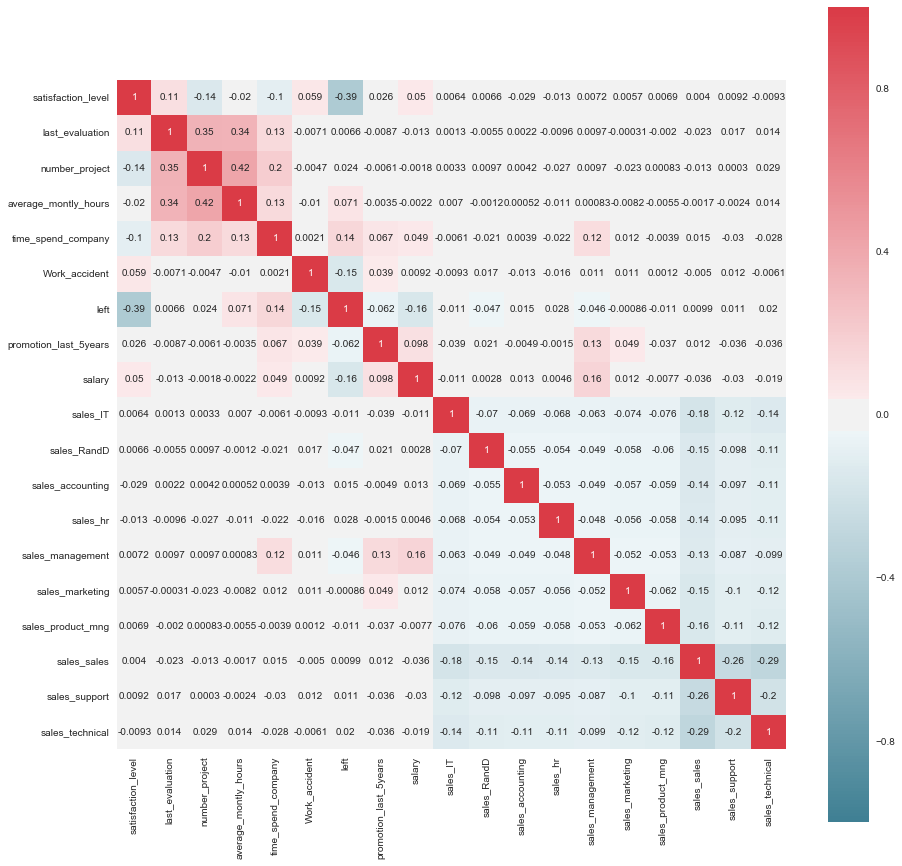

In [10]:
f, ax = plt.subplots(figsize=(15, 15))
corr = dataset.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)
plt.show()

We can see that the main correlation between the fact that an employee leave and other parameter is mostly :
<ul>
<li>the satisfaction : if the employee is bored at work,, He will probably look for another job </li>
<li>the evaluation : This can be a bit less obvious. If you have bad evaluation, you may think that you are not made for this job and want to leave but if it's too high, you can expect changing position</li>
<li>the number of project : If you have too much project, you can be tired of this position and if you don't have enought you may be bored</li>
</ul>

Let's quickly explore if there is a pattern

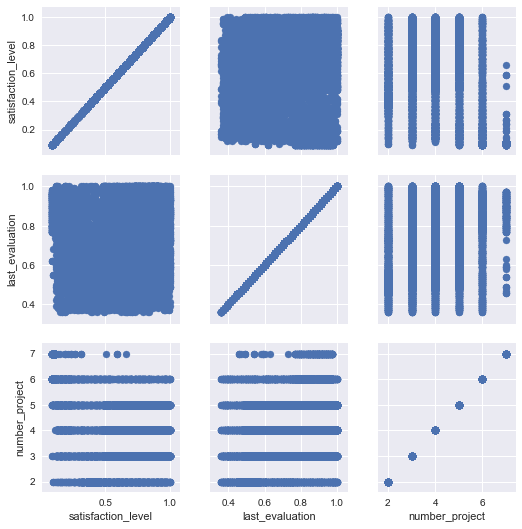

In [11]:
g = sns.PairGrid(dataset_raw[["satisfaction_level", "last_evaluation", "number_project"]])
g.map(plt.scatter);

In [12]:
satisfaction_left = dataset[dataset["left"] == 1]["satisfaction_level"]
print(satisfaction_left.mean())
satisfaction_remain =  dataset[dataset["left"] == 0]["satisfaction_level"]
print(satisfaction_remain.mean())

0.44009801176140917
0.666809590479516


We can see that the satisfaction of people who left the company is below the average. This is logical. We can also plot an histogram of the distribution 

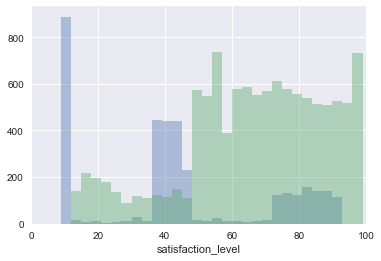

In [13]:
x = 100*satisfaction_left
y = 100*satisfaction_remain
nb_bins = 30

fig, ax = plt.subplots()
for a in [x, y]:
    sns.distplot(a, bins=range(0, 100, 100//nb_bins), ax=ax, kde=False)
ax.set_xlim([0, 100])
plt.show()

As expected, people with no satifaction left, people with low satifaction mostly left. We also can see that a part of employee highly satisfied left. This is probably because they found a better position somewhere else in the meantime. We can do the same with the last evaluation

0.7181125735088183
0.7154733986699274


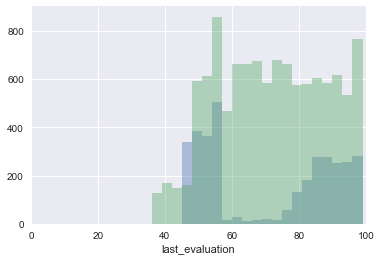

In [14]:
eval_left = dataset[dataset["left"] == 1]["last_evaluation"]
print(eval_left.mean())
eval_remain =  dataset[dataset["left"] == 0]["last_evaluation"]
print(eval_remain.mean())

x = 100*eval_left
y = 100*eval_remain
nb_bins = 30

fig, ax = plt.subplots()
for a in [x, y]:
    sns.distplot(a, bins=range(0, 100, 100//nb_bins), ax=ax, kde=False)
ax.set_xlim([0, 100])
plt.show()

This is also splitted in 2 buckets. One for people with "bad" evaluation. In that case, around 33% of people left. There is also talent who left (evaluation > 8/10). This bucket is also probably a part of satified people who found a better place somewhere else. You have the count below

In [15]:
talent_left = dataset[(dataset["left"] == 1) & (dataset["last_evaluation"] > 0.75)]["left"].count()
print(talent_left)
satisfied_left = dataset[(dataset["left"] == 1) & (dataset["satisfaction_level"] > 0.75)]["left"].count()
print(satisfied_left)

1869
768


So 1869 ppl left with a note above 7.5/10 at evaluation and 768 had a satisfaction above 0.75. We can also check the impact of number of project or salary

3.8555026603192384
3.786664333216661


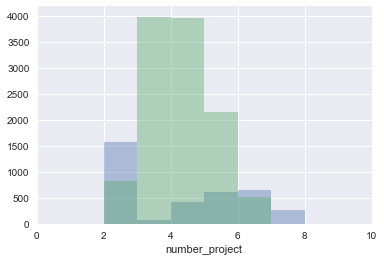

In [16]:
eval_left = dataset[dataset["left"] == 1]["number_project"]
print(eval_left.mean())
eval_remain =  dataset[dataset["left"] == 0]["number_project"]
print(eval_remain.mean())

x = eval_left
y = eval_remain
nb_bins = 30

fig, ax = plt.subplots()
for a in [x, y]:
    sns.distplot(a, bins=range(0, 10, 1), ax=ax, kde=False)
ax.set_xlim([0, 10])
plt.show()

We can see that people with few project usually left. This is probably because thay are bored or bad at their position and a slower. There is also a bucket with high number of project. This is more likely due to discouragement

1.4147297675721087
1.6509450472523626


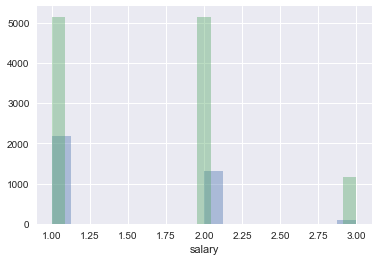

In [17]:
eval_left = dataset[dataset["left"] == 1]["salary"]
print(eval_left.mean())
eval_remain =  dataset[dataset["left"] == 0]["salary"]
print(eval_remain.mean())

x = eval_left
y = eval_remain
nb_bins = 30

fig, ax = plt.subplots()
for a in [x, y]:
    sns.distplot(a, ax=ax, kde=False)
plt.show()

0.0595611285266
0.241961852861


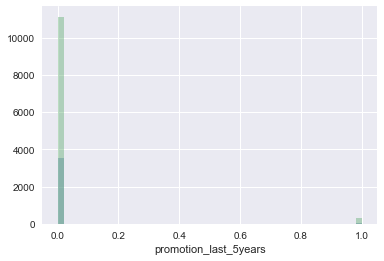

In [18]:
eval_left = dataset[dataset["left"] == 1]["promotion_last_5years"]
eval_remain =  dataset[dataset["left"] == 0]["promotion_last_5years"]

a = dataset[(dataset["left"] == 1) & (dataset["promotion_last_5years"] == 1)]["promotion_last_5years"].count()
b = dataset[(dataset["left"] == 0) & (dataset["promotion_last_5years"] == 1)]["promotion_last_5years"].count()

print(a/(a+b))

a = dataset[(dataset["left"] == 1) & (dataset["promotion_last_5years"] == 0)]["promotion_last_5years"].count()
b = dataset[(dataset["left"] == 0) & (dataset["promotion_last_5years"] == 0)]["promotion_last_5years"].count()

print(a/(a+b))

x = eval_left
y = eval_remain
nb_bins = 30

fig, ax = plt.subplots()
for a in [x, y]:
    sns.distplot(a, ax=ax, kde=False)
plt.show()

We can see that there is only few high salary and on this part, there is nearly noone leaving. For Low Salary around 33% leave and for Medium Salary is more around 25%. In people who got a promotion, only 5 percent left. In those who didn't get it, 24% left. 

So now we know better the dataset and we can setup some models

# Setup models

In this section, we gonna apply some classifier, evaluation them on accuracy (knowing that a dummy classifier can easily have 75 % success due to the unbalanced dataset). But first of all, we just goona extract some line of people remaining in the company for the final evaluation.

In [19]:
temp = dataset.index[dataset["left"] == 0].tolist()
idx = random.sample(temp, 50)
X_eval = dataset.iloc[idx].drop("left", axis=1)

dataset = dataset.drop(dataset.index[idx])

We can now, scale the dataset and prepare our train and test dataset

In [20]:
X = dataset.drop("left", axis=1)
y = dataset["left"]
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

And finally we can benchmark some classical classifier

In [22]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
acc = model.score(X_test, y_test)
print(acc)
print(confusion_matrix(y_test, model.predict(X_test)))

0.976588628763
[[2241   51]
 [  19  679]]


With DecisionTree, we can also display the logical usign graphviz. This tree is huge but can be used by anybody to predict it manually

In [23]:
header = list(dataset.columns)
export_graphviz(model, out_file="mytree.dot", feature_names=header)

In [24]:
from IPython.display import Image
Image("image.png")

In [25]:
model = SGDClassifier()
for i in range(10):
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print(i, acc)
    print(confusion_matrix(y_test, model.predict(X_test)))

0 0.789632107023
[[2167  125]
 [ 504  194]]
1 0.77491638796
[[2275   17]
 [ 656   42]]
2 0.783612040134
[[2201   91]
 [ 556  142]]
3 0.79364548495
[[2244   48]
 [ 569  129]]
4 0.818060200669
[[2048  244]
 [ 300  398]]
5 0.783946488294
[[1906  386]
 [ 260  438]]
6 0.741471571906
[[1753  539]
 [ 234  464]]
7 0.803678929766
[[1961  331]
 [ 256  442]]
8 0.763545150502
[[1879  413]
 [ 294  404]]
9 0.798327759197
[[2166  126]
 [ 477  221]]


In [26]:
model = BaggingClassifier()
model.fit(X_train, y_train)
acc = model.score(X_test, y_test)
print(acc)
print(confusion_matrix(y_test, model.predict(X_test)))

0.990301003344
[[2284    8]
 [  21  677]]


In [27]:
model = AdaBoostClassifier()
model.fit(X_train, y_train)
acc = model.score(X_test, y_test)
print(acc)
print(confusion_matrix(y_test, model.predict(X_test)))

0.961872909699
[[2237   55]
 [  59  639]]


In [28]:
model = GradientBoostingClassifier()
model.fit(X_train, y_train)
acc = model.score(X_test, y_test)
print(acc)
print(confusion_matrix(y_test, model.predict(X_test)))

0.975919732441
[[2270   22]
 [  50  648]]


In [29]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
acc = model.score(X_test, y_test)
print(acc)
print(confusion_matrix(y_test, model.predict(X_test)))

0.989297658863
[[2288    4]
 [  28  670]]


In [30]:
model = MLPClassifier()
model.fit(X_train, y_train)
acc = model.score(X_test, y_test)
print(acc)
print(confusion_matrix(y_test, model.predict(X_test)))

0.955852842809
[[2221   71]
 [  61  637]]


In [31]:
model = SVC()
model.fit(X_train, y_train)
acc = model.score(X_test, y_test)
print(acc)
print(confusion_matrix(y_test, model.predict(X_test)))

0.880267558528
[[2252   40]
 [ 318  380]]


In [ ]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
acc = model.score(X_test, y_test)
print(acc)
print(confusion_matrix(y_test, model.predict(X_test)))

0.941137123746
[[2193   99]
 [  77  621]]


# Using NN

We can also try a simple NN. As we have only 15k entries, we cannot have a too deep model whiwh will be difficult to train and having risks to overfit.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.np_utils import to_categorical

y_train_cat = to_categorical(y_train)

Using TensorFlow backend.


In [ ]:
model = Sequential()

model.add(Dense(units=40, input_dim=X.shape[1]))
model.add(Activation('relu'))
model.add(Dense(units=40))
model.add(Activation('relu'))
model.add(Dense(units=20))
model.add(Activation('relu'))
model.add(Dense(units=2))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train_cat, epochs=250, batch_size=128)

Accuracy of 96 % is not so bad, maybe more epoch could lead to slighly more accuracy but not that much. We can also prot the accuracy of the prediction

In [ ]:
eval_dataset = dataset[dataset["left"] == 0]
X = eval_dataset.drop("left", axis=1)
y = eval_dataset["left"]
X = scaler.transform(X)

In [ ]:
classes = model.predict(X, batch_size=128)
print(classes)

In [ ]:
fig, ax = plt.subplots()
for a in [classes[:,0], classes[:,1]]:
    sns.distplot(a, ax=ax, kde=False)
plt.show()

Our model, sligly separate both classes. there is nearly nne at the middle (which is also logical as we trained the model on those entries)

# Fine Tune best models

Now we have our 2 best models <b>RandomForestClassifier</b> and <b>BaggingClassifier</b>. We can fine tune them usign a GridSearch

In [ ]:
parameters = {"n_estimators" : [10, 50, 100, 150], "max_depth": [None, 5, 10], "bootstrap" : [True, False]}
model = RandomForestClassifier()
clf = GridSearchCV(model, parameters, cv=5, scoring="accuracy")
clf.fit(X, y)

cvres = clf.cv_results_
for score, param in zip(cvres["mean_test_score"], cvres["params"]):
    print(score, param)

In [ ]:
best_1 = clf.best_estimator_  #{'bootstrap': False, 'max_depth': None, 'n_estimators': 50} => 0.991599439963

In [ ]:
print(best_1.get_params)

In [ ]:
parameters = {"n_estimators" : [10, 20, 50, 100], "max_samples": [0.1, 0.5, 0.9, 1], "max_features" : [0.1, 0.5, 0.9, 1]}
model = BaggingClassifier()
clf = GridSearchCV(model, parameters, cv=5, scoring="accuracy")
clf.fit(X, y)

cvres = clf.cv_results_
for score, param in zip(cvres["mean_test_score"], cvres["params"]):
    print(score, param)

In [ ]:
best_2 = clf.best_estimator_  # {'max_features': 0.9, 'max_samples': 0.9, 'n_estimators': 100} => 0.991066071071

In [ ]:
final_model = best_1

# Find the most probable next employee to leave

Now we have the best model and good parameters. We can now use it on evaluation dataset. This dataset is only people who are still in the company. The objective is to predict the probability of both classes. As our classier is good (aroudn 99 % accuracy). The result can be understand to the probability for this employee to leave.

In [ ]:
final_model = RandomForestClassifier(bootstrap=False, n_estimators=50)
final_model.fit(X_train, y_train)

In [ ]:
eval_dataset = dataset[dataset["left"] == 0]

In [ ]:
X = eval_dataset.drop("left", axis=1)
y = eval_dataset["left"]

In [ ]:
X = scaler.transform(X)

In [ ]:
y_pred = final_model.predict(X_eval)
y_prob = final_model.predict_proba(X_eval)

In [ ]:
for x, y in zip(y_pred, y_prob):
    print(x, y)

We can see that our model predict some employees as "left". That means it's probable that the employee is willing to leave for another company. In those employee, we can review in case by case and maybe trying to improve their satisfaction. We found some lever on the first section.

# Conclusion

As a conclusion, we have a model which predict properly if the employee wants to leave. Nevertheless, as we didn't limit the size of trees, we may slightly be overfitting. Also the current drawback on this model is that we cannot evaluate it on the complete company. We only have to select some selected people. This is beacuse we need employees still in the company to train the model and we cannot use them anymore (it's more true with Tree Classifier). 